In [1]:
import os
import sys
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold

/Users/Majid/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# ID    UTTERANCE    CORE RELATIONS
trainFile = pd.read_csv('dataset/hw1_train.csv')
# ID    UTTERANCE
testFile = pd.read_csv('dataset/hw1_test.csv')

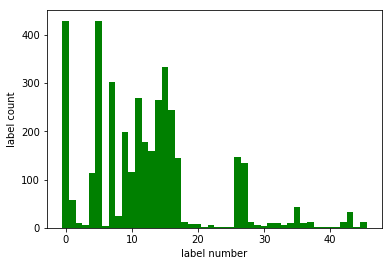

In [3]:
unique_relations = {}
for relation_str in trainFile['CORE RELATIONS']:
    relations = relation_str.split(' ')
    for relation in relations:
        if relation in unique_relations:
            unique_relations[relation] += 1
        else:
            unique_relations[relation] = 1
            
import matplotlib.pyplot as plt
plt.bar(list(range(len(unique_relations))), unique_relations.values(), 1, color='g')
plt.ylabel('label count')
plt.xlabel('label number')
plt.show()

In [4]:
# Data preparation

# input features
X = list(trainFile['UTTERANCE'])

unique_relations = []
for relation_str in trainFile['CORE RELATIONS']:
    relations = relation_str.split(' ')
    for relation in relations:
        if relation not in unique_relations:
            unique_relations.append(relation)

unique_nodes = []
for path in unique_relations:
    nodes = path.split('.')
    for node in nodes:
        if node not in unique_nodes:
            unique_nodes.append(node)

# add label columns to dataframe
for relation in unique_relations:
    trainFile[relation] = 0

# fill out label columns
for idx, relation_str in enumerate(trainFile['CORE RELATIONS']):
    relations = relation_str.split(' ')
    for relation in relations:
        trainFile.loc[idx,relation] = 1

#separate label columns
labels = trainFile[unique_relations]

# target values
y = labels.values


In [5]:
# 5000 words because the training set has almost 2500 unique words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_matrix(X)

In [6]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def create_model(hyperParams):
    
    hidden_layers = hyperParams['hidden_layers']
    activation = hyperParams['activation']
    dropout = hyperParams['dropout']
    output_activation = hyperParams['output_activation']
    loss = hyperParams['loss']
    
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_shape=(5000,), activation=activation))
    model.add(Dropout(dropout))
    for i in range(len(hidden_layers)-1):
        model.add(Dense(hidden_layers[i], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(46, activation=output_activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy', f1_score])
    # categorical_crossentropy, binary_crossentropy f1_loss->(for tensorflow 1.14)
    
    return model

In [8]:
def cv_model_fit(X, y, hyperParams):
    
    kfold = KFold(n_splits=10, shuffle=True)
    scores=[]
    for train_idx, test_idx in kfold.split(X):
        model = create_model(hyperParams)
        model.fit(X[train_idx], y[train_idx], batch_size=hyperParams['batch_size'], 
                   epochs=hyperParams['epochs'], verbose=0)
        score = model.evaluate(X[test_idx], y[test_idx], verbose=0)
        scores.append(score[2]*100) # f_score
        print('fold ', len(scores), '  score: ', scores[-1])
        del model
        
    return scores

In [ ]:
# hyper parameter optimization
from itertools import product

# default parameter setting:
hyperParams = {'batch_size': 32, 'epochs': 25, 'hidden_layers': [512, 512], 'activation': 'relu', 'dropout': 0.3,
              'output_activation': 'sigmoid', 'loss': 'binary_crossentropy'}

# parameter search space:
batch_chices = [8, 16, 32, 64, 128]
epochs_choices = [10, 15, 25, 40, 70, 100]
hidden_layers_choices = [[512, 512], [128, 128, 128], [256, 256, 256], [512, 512, 512],
                         [256, 512, 256], [128, 256, 128], [128, 512, 128], [512, 512, 128],
                         [512, 1024, 512], [1024, 512, 512, 256], [1024, 512, 512, 128], [1024, 1024, 1024, 512]]
activation_choices = ['relu', 'sigmoid', 'tanh']
dropout_choices = [0.3, 0.5, 0.8]

s = [batch_chices, epochs_choices, hidden_layers_choices, activation_choices, dropout_choices]
perms = list(product(*s))  # permutations

# Linear search:
best_score = 0
for row in perms:
    hyperParams['batch_size'] = row[0]
    hyperParams['epochs'] = row[1]
    hyperParams['hidden_layers'] = row[2]
    hyperParams['activation'] = row[3]
    hyperParams['dropout'] = row[4]
    print('10-fold cross validation on these hyperparameters: ', hyperParams, '\n')
    cvscores = cv_model_fit(X, y, hyperParams)
    print('\n-------------------------------------------')
    mean_score = np.mean(cvscores)
    std_score = np.std(cvscores)
    # Update the best parameter setting:
    print('CV mean: {0:0.4f},  CV std: {1:0.4f}'.format(mean_score, std_score))
    if  mean_score > best_score:    # later I should incorporate std in best model selection
        best_score = mean_score
        print('****** Best model so far ******')
        best_params = hyperParams
    print('-------------------------------------------\n')

In [ ]:
# build last model from full data using best parameter setting
model = create_model(best_params)
history = model.fit(X, y, batch_size=best_params['batch_size'], epochs=best_params['epochs'], 
                    verbose=1)

In [29]:
# load test data and convert to vector
X_t = list(testFile['UTTERANCE'])
X_pred = tokenizer.texts_to_matrix(X_t)

In [30]:
# generate predictions
y_pred = model.predict(X_pred)

In [31]:
# Tailor predictions and generate string labels
predictions = []
for y in y_pred:
    temp = []
    for i,v in enumerate(y):
        if v >= 0.5:
            temp.append(unique_relations[i])
    if len(temp) < 1:   # select max if no prob >= 0.5
        temp.append(unique_relations[np.argmax(y)])
    if (len(temp) > 1) and ('other' in temp):   # remove 'other' if more than 1 labels
        temp.remove('other')
    if (len(temp) > 1) and ('NO_REL' in temp):   # remove 'NO_REL' if more than 1 labels
        temp.remove('NO_REL')
    if (len(temp) > 1) and ('movie_other' in temp):   # remove 'movie_other' if more than 1 labels
        temp.remove('movie_other')
    predictions.append(' '.join(temp))

In [32]:
# Save submision file
submissionFile = pd.DataFrame({
    'ID': [i for i in range(len(predictions))],
    'CORE RELATIONS': predictions})
path_to_save = os.path.abspath(os.getcwd()) + '/predictions/'
submissionFile.to_csv('predictions/predictions.csv', index = None)
submissionFile.head()

,CORE RELATIONS,ID
0,movie.starring.actor,0
1,movie.starring.actor,1
2,movie.starring.actor,2
3,movie.starring.actor,3
4,movie.starring.actor,4
